In [1]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
import statsmodels
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from collections import defaultdict
from tqdm.notebook import tqdm


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

from mri_data import file_manager as fm

## Load Data

In [2]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/sdmt_regressions"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")

df = df.join([choroid_volumes, tiv, sdmt['SDMT'], df_thomas['1-THALAMUS']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df.rename(columns={'1-THALAMUS': 'THALAMUS_1'}, inplace=True)

df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

df_ms = df[df['dz_type2'] == "MS"]
df_ms_z = df_ms.copy()
df_ms_z[numeric_cols] = df_ms_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

# assert df.loc[1340, 'EDSS'] == 2.5

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

## Functions

In [3]:
def plot_regression(
    data, predictor, outcome, covariates, xlabel=None, ylabel=None, title=None
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [['histx', '.'], ['scatter', 'histy']],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout='constrained',
    )

    helpers.scatter_hist(
        data[predictor],
        data[outcome],
        axs['scatter'],
        axs['histx'],
        axs['histy'],
        light_color=colors['light blue1'],
        dark_color=colors['dark blue1'],
    )

    axs['scatter'].plot(x, y_pred, color="black")
    axs['scatter'].fill_between(
        x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light blue1"]
    )
    axs['scatter'].set_ylabel(ylabel)
    axs['scatter'].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs

## Assumption Checks

SDMT looks normal enough, probably don't need to test further

(array([  4.,  18.,  23.,  50.,  70., 110.,  95.,  50.,  25.,   9.]),
 array([11. , 18.6, 26.2, 33.8, 41.4, 49. , 56.6, 64.2, 71.8, 79.4, 87. ]),
 <BarContainer object of 10 artists>)

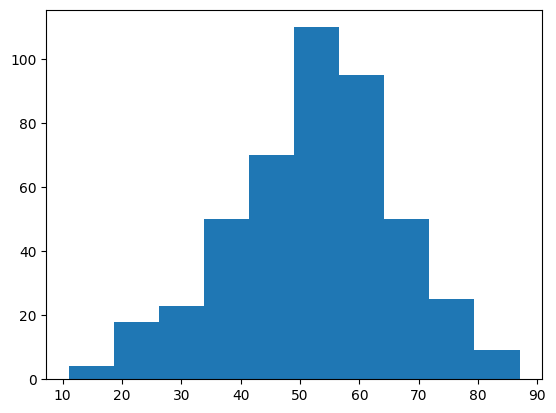

In [4]:
plt.hist(df['SDMT'])

## Regressions

Regress SDMT against various MRI features independently

In [ ]:
model_data = df_ms_z.join()
covariates = "age + Female + tiv"

outcome = "SDMT"
predictors = [
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "THALAMUS_1",
    "t2lv",
    "PRL",
    "choroid_volume",
]

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
r2 = {}
ci_str = {}

for x in predictors:
    formula = f"{outcome} ~ {x} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[x] = res.pvalues[x]
    coefs[x] = res.params[x]
    stderrs[x] = res.HC0_se[x]
    ci = res.conf_int()
    llci[x] = ci.loc[x, 0]
    ulci[x] = ci.loc[x, 1]
    ci_str[x] = f"[{llci[x]:.6f}, {ulci[x]:.6f}]"
    r2[x] = res.rsquared_adj


regression_results = pd.DataFrame(
    {
        "coef": coefs,
        "stderr": stderrs,
        "llci": llci,
        "ulci": ulci,
        "pvals": pvals,
        "ci": ci_str,
    }
)
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.index.name = "structure"
regression_results.to_excel(fig_path / "SDMT_and_main_mri_features_MS.xlsx")
regression_results


,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
structure,,,,,,,,
brain,0.233121,0.046616,0.136631,0.329612,2.766091e-06,"[0.136631, 0.329612]",4.425746e-06,0.195320
white,0.104404,0.046018,0.013419,0.195390,2.460754e-02,"[0.013419, 0.195390]",2.460754e-02,0.164381
grey,0.291232,0.048228,0.190863,0.391600,2.143769e-08,"[0.190863, 0.391600]",4.287538e-08,0.211987
cortical_thickness,0.361019,0.047684,0.269593,0.452445,5.762797e-14,"[0.269593, 0.452445]",4.610238e-13,0.254860
THALAMUS_1,0.358671,0.055096,0.263383,0.453960,6.881416e-13,"[0.263383, 0.453960]",2.752566e-12,0.246721
t2lv,-0.266237,0.073334,-0.349392,-0.183082,7.447195e-10,"[-0.349392, -0.183082]",1.985919e-09,0.223395
PRL,-0.145967,0.047596,-0.233574,-0.058360,1.140599e-03,"[-0.233574, -0.058360]",1.412644e-03,0.174626
choroid_volume,-0.157975,0.055039,-0.253469,-0.062481,1.236063e-03,"[-0.253469, -0.062481]",1.412644e-03,0.174353


### SDMT in PMS vs RMS

Patients with PMS had lower SDMT after adjusting for age, sex, and TIV

In [58]:
model_data = df_ms_z.copy()
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'], dtype="int")), axis=1
)

formula = "PMS ~ SDMT + age + tiv + Female"
res = sm.Logit.from_formula(formula, data=model_data).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.341385
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    PMS   No. Observations:                  454
Model:                          Logit   Df Residuals:                      449
Method:                           MLE   Df Model:                            4
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.3306
Time:                        17:57:41   Log-Likelihood:                -154.99
converged:                       True   LL-Null:                       -231.55
Covariance Type:            nonrobust   LLR p-value:                 4.366e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1913      0.206    -10.636      0.000      -2.595      -1.788
SDMT          -0.9455      0.